In [1]:
from IBISA import * 
from torchvision.models import resnet50
from PIL import Image

In [2]:
# Defining the model
core = resnet50(weights = 'DEFAULT')
core.eval()
core = core.to(device)

input_size = 224
k = input_size*input_size*3
transform = transforms.Compose([transforms.Resize((input_size,input_size)),
                            transforms.ToTensor()])    

epochs = 10
n_masks = 20

In [3]:
# Placing the bottleneck right after the input
new_layer = InfoLayer(mask_range=3, mask_size=7, input_size=input_size)
new_layer = new_layer.to(device=device)

new_core = InfoModel(core=core, bottleneck=new_layer)
new_core = new_core.to(device=device)

P = list(new_core.parameters())
optimizer = torch.optim.Adam(P, lr=1)

loss_ce = nn.CrossEntropyLoss()
loss_inf = InfoLoss(beta=100/k, phi=100/k)

In [4]:
# Image to be explained
pil_img = Image.open('./demo_images/test_image.JPEG').convert('RGB')

img = transform(pil_img)
x = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(img)
x = x[None,...].to(device)

In [5]:
preds = core(x)
y = torch.argmax(preds, dim=1)
y = y.to(device)

In [6]:
s = 0 
for _ in range(n_masks):
    new_core.reset_model()
    s += train_bottleneck(model=new_core, x=x, y=y, loss_ce=loss_ce, loss_inf=loss_inf, sigma=1, opt=optimizer, epochs=epochs)  

In [7]:
s = torch.squeeze(s)
s = s.detach().cpu().numpy()

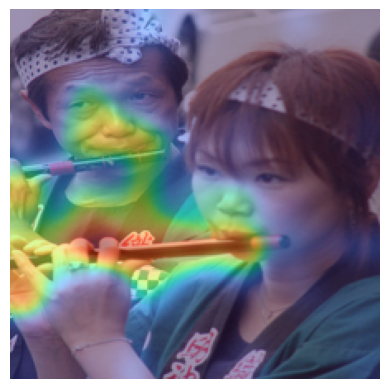

In [8]:
plt.imshow(pil_img.resize((input_size,input_size)))
plt.imshow(s, cmap='turbo', alpha=0.5)
plt.axis('off')
plt.show()